# BrainPy Quickstart

Two main functions are provided in BrainPy: **neurodynamics simulation** and **neurodynamics analysis**. In this part, I will focus on neuronal dynamics simulation, and tell you how to code a dynamical network in BrainPy bu using the example of *(Wang & Buzsáki, 1996)*.

- Wang, Xiao-Jing, and György Buzsáki. "Gamma oscillation by synaptic inhibition in a hippocampal interneuronal network model." Journal of neuroscience 16.20 (1996): 6402-6413.

*(Wang & Buzsáki, 1996)* demonstrates how a group of neuron with mutual inhibition produce the gamma oscillation (20–80 Hz) observed in the neocortex and hippocampus. In this network model, the neurons are modeled as a variant of Hodgkin–Huxley (HH) neuron model, and the inhibition connections between neurons are modeled as the GABA<sub>A</sub> synapses.

Here, we will first build a HH neuron model. Then, construct a GABA<sub>A</sub> synapse model. Finally, combining the HH model and GABA<sub>A</sub> moldel together, we will build a network model. We expect at the suitable parameter regions, the network will produce gamma oscillation.

First of all, import your favorite ``brainpy`` and ``numpy`` package.

In [1]:
import brainpy as bp
import numpy as np

In BrainPy, all the system-level settings are implmented in ``bp.profile``. By using ``bp.profile``, you can set the backend or the device of the models going to run on, the method and the precision of the numerical integrator, etc. Before diving into this tutorial, let's set the necessary profiles:

In [2]:
bp.profile.set(jit=True,
               device='cpu',
               dt=0.04,
               numerical_method='exponential')

This setting means we will JIT compile our model on ``cpu`` device, the default numerical method is set to [exponential euler method](https://brainpy.readthedocs.io/en/latest/advanced/numerical_integrators.html) (``exponential``), and the numerical step is set to ``0.04``.

## How to build a neuron model?

In BrainPy, the solving of differential equations is based on [numerical methods](https://brainpy.readthedocs.io/en/latest/advanced/numerical_integrators.html), such as Euler method, Runge–Kutta methods. Therefore, the definition of a neuron/synapse model is the definition of the *step functions* which explicitly point out how variable state at the current time point $x(t)$ is transited to the next time point $x(t+1)$.

Let's take the neuron model as an example. 

To build a neuron model in BrainPy is to create an instance of ``NeuType``. The instantiation of ``NeuType`` requires three items:

- *ST*: The neuron model state.
- *steps*: The step function to update at each cycle of run.
- *name* : The name of the neuron model (will be useful in error reporting and debugging).

Here, we are going to create a HH neuron model. The parameters of HH model are defined in the follows:

In [3]:
V_th = 0.  # the spike threshold
C = 1.0  # the membrane capacitance
gLeak = 0.1  # the conductance of leaky channel
ELeak = -65  # the reversal potential of the leaky channel
gNa = 35.  # the conductance of sodium channel
ENa = 55.  # the reversal potential of sodium
gK = 9.  # the conductance of potassium channel
EK = -90.  # the reversal potential of potassium
phi = 5.0  # the temperature depdendent scaling  

In this variant of HH model, three dynamical variables ($V$, $h$ and $n$) exist.

**Coding the differential equations**

For any [ordinary differential equation](https://brainpy.readthedocs.io/en/latest/advanced/differential_equations.html)

$$
{dx \over dt} = f(x, t)
$$

you only need write down the right-hand part of the differential equations $f(x, t)$. By adding a powerfull decorator porovided by BrainPy, ``@bp.integrate``, the framework will automatically numerically integrate the defined equations. Generally, an ordinary differential equation in BrainPy can be coded as:

In [4]:
@bp.integrate
def func(x, t, other_arguments):
    # ... some computation ...
    dxdt = ...
    return dxdt

``@bp.integrate`` receives ``method`` keyword to specify the numerical method you want to choose. For example, adding ``@bp.integrate(method='rk4')`` means you integrate the decorated function by using Fouth-order Runge–Kutta method (The full list of supportted numerical integrators please see the document of [Numerical integrators](https://brainpy.readthedocs.io/en/latest/guides/numerical_integrators.html)). Otherwise, the differential function will be integrated by the system default method.

Specifically, for **h channel**, the differential equation is mathematically formed as:

$$
\begin{align}
{\frac {dh}{dt}} &=\alpha _{h}(V)(1-h)-\beta _{h}(V)h \\
\alpha_h(V) &= 0.07 \cdot \exp\big(-{V+58 \over 20}\big) \\
\beta_h(V) &= {1 \over 1 + \exp\big(-{V+28\over 10}\big)}
\end{align}
$$

In BrainPy, you can code $h$ channel equation like this:

In [4]:
@bp.integrate
def int_h(h, t, V):
    alpha = 0.07 * np.exp(-(V + 58) / 20)
    beta = 1 / (np.exp(-0.1 * (V + 28)) + 1)
    dhdt = alpha * (1 - h) - beta * h
    return phi * dhdt

The differential equation of **n channel**

$$
\begin{align}
{\frac {dn}{dt}} &=\alpha _{n}(V)(1-n)-\beta _{n}(V)n \\
\alpha_n(V) &= {0.01 \cdot (V+34) \over 1-\exp\big(-{V+34 \over10}\big)} \\
\beta_n(V) &= 0.125 \cdot \exp\big(-{V+44 \over 80}\big)
\end{align}
$$

can be coded as:

In [5]:
@bp.integrate
def int_n(n, t, V):
    alpha = -0.01 * (V + 34) / (np.exp(-0.1 * (V + 34)) - 1)
    beta = 0.125 * np.exp(-(V + 44) / 80)
    dndt = alpha * (1 - n) - beta * n
    return phi * dndt

Finally, the differential equation of **membrane potential V** is expressed as:

$$
\begin{align}
C_{m}{\frac {d V}{dt}}&=-{\bar {g}}_{\text{K}}n^{4}(V-V_{K}) - {\bar {g}}_{\text{Na}}m^{3}h(V-V_{Na}) -{\bar {g}}_{l}(V-V_{l}) + I_{syn}
\end{align}
$$

where $m$ is modeled as an instaneous channel (fast enough and substituted by its steady-state function)


$$
\begin{align}
\alpha_m(V) &= {0.1 (V+ 40) \over 1-\exp\big(-{ V+40 \over 10}\big)} \\
\beta_m(V) &= 4.0 \cdot \exp\big(-{V+65 \over 18}\big) \\
m &= {\alpha_m(V) \over \alpha_m(V) + \beta_m(V)}
\end{align}
$$

Therefore, the differential equations of $V$ is coded as:

In [6]:
@bp.integrate
def int_V(V, t, h, n, Isyn):
    m_alpha = -0.1 * (V + 35) / (np.exp(-0.1 * (V + 35)) - 1)
    m_beta = 4 * np.exp(-(V + 60) / 18)
    m = m_alpha / (m_alpha + m_beta)
    INa = gNa * m ** 3 * h * (V - ENa)
    IK = gK * n ** 4 * (V - EK)
    IL = gLeak * (V - ELeak)
    dvdt = (- INa - IK - IL + Isyn) / C
    return dvdt

**Neuron state**

In order to support the convenient state management, BrainPy provides ``NeuState`` to help you manage your model state. 

In HH neuron, there are $V$, $h$ and $n$ dynamical variables. Moreover, the *input* of the neuron is time-varying. We can add a ``input`` item in HH neuron state to receive the varying input. Further, the neuron *spike* is also we take care of. So, the neuron state of HH model can be specified as

In [7]:
HH_ST = bp.types.NeuState({
    'V': -55.,  # membrane potential, default initial value is -55.
    'h': 0.,  # h channel, default initial value is 0.
    'n': 0.,  # n channel, default initial value is 0.
    'spike': 0.,  # neuron spike state, default initial value is 0., 
                  # if neuron emits a spike, it will be 1.
    'input': 0.  # neuron synaptic input, default initial value is 0.
})

The instantiation of ``bp.types.NeuState`` can receive a dict (which means the fields and their default initial values), or a list/tuple of fields (in this case the default initial value will be set to 0.).

**Step functions**

For each model, the most important thing is to define the step functions. After the definition of differential equations, the step function of the HH model can be defined as: 

In [8]:
def update(ST, _t):
    h = int_h(ST['h'], _t, ST['V'])
    n = int_n(ST['n'], _t, ST['V'])
    V = int_V(ST['V'], _t, ST['h'], ST['n'], ST['input'])
    sp = np.logical_and(ST['V'] < V_th, V >= V_th)
    ST['spike'] = sp
    ST['V'] = V
    ST['h'] = h
    ST['n'] = n
    ST['input'] = 0.

To define a step function, you can pass any data you need into the function as the functional arguments. The order of the arguments in each step function can be arbitrary.

In HH model step function, as you can see, two arguments are required:

- ``ST``: the neuron state.
- ``_t``: the current time. 

``_t`` is a system keyword, which denotes the current time point. In BrainPy, there are three system keywords: ``_t``, ``_i`` (the current running step number), and ``_dt`` (the numerical integration step).

**Define a NeuType**

Finally, putting the above together, we get our HH neuron model as:

In [9]:
HH = bp.NeuType(ST=HH_ST, name='HH_neuron', steps=update)

More advanced usage of ``NeuType`` definition please see [Build Neurons](https://brainpy.readthedocs.io/en/latest/tutorials/build_neurons.html).

## How to build a synapse model?

Like the ``NeuType`` definition, let's announce the parameters all we need in the following:

In [10]:
g_max = 0.1  # the maximal synaptic conductance
E = -75.  # the reversal potential
alpha = 12.  # the channel opening rate
beta = 0.1  # the channel closing rate

The GABA<sub>A</sub> synapse defined in *(Wang & Buzsáki, 1996)* is mathematically expressed as 

$$
\begin{align}
\frac{ds}{dt} &= \alpha F(V_{pre})(1-s)-\beta s   \quad (1) \\
F(V_{pre}) &= {1 \over 1+\exp\left(-{V_{pre}- V_{th} \over 2}\right)}  \quad (2) 
\end{align}
$$

The synaptic current output onto the post-synaptic neuron is expressed as

$$
I_{ syn }=g_{max} s\left(V-E\right) \quad (3)
$$

Obviously, GABA<sub>A</sub> synapse model has one dynamical variable `s`. Thus, we can create the synapse state by using  

In [11]:
ST = bp.types.SynState(['s'])

Based on the equation (1) and (2), the state updating of GABA<sub>A</sub> synapse is coded as: 

In [12]:
@bp.integrate
def int_s(s, t, TT):
    return alpha * TT * (1 - s) - beta * s

def update(ST, _t, pre):
    T = 1 / (1 + np.exp(-(pre['V'] - V_th) / 2))
    s = int_s(ST['s'], _t, T)
    ST['s'] = s

Moreover, based on the equation (3), the delayed synaptic value output onto the post-synaptic neurons of GABA<sub>A</sub> synpase can be coded as:

In [13]:
@bp.delayed
def output(ST, post):
    post['input'] -= g_max * ST['s'] * (post['V'] - E)

The decorator ``@bp.delayed`` can be added on the function which need the delayed ``ST``. BrainPy will automatically recognize the delayed fileds. For example, in this ``output()`` function, the field ``s`` will be automatically delayed. When calling ``output()``, the ``ST['s']`` will be the delayed one.

Moreover, as you can see, the definition of the GABA<sub>A</sub> synapse requires the following data:

- ``pre``: The pre-synaptic neuron state, in which the field ``V`` is needed to compute the synapatic state.
- ``post``: The post-synaptic neuron state, in which the fields ``V`` and ``input`` are needed.

If you use this model defined by yourself, you clearly know what data you need to run the model. However, when somebody use your defined model, they will be confused by what ``pre`` and ``post`` mean. So, here we can make declarations (optional):

In [14]:
requires = dict(
    pre=bp.types.NeuState(['V']),
    post=bp.types.NeuState(['V', 'input']),
)

Finally, let's put the above difinitions together, and we get our wantted synapse model:

In [15]:
GABAa = bp.SynType(ST=ST,
                   name='GABAa', 
                   steps=(update, output), 
                   requires=requires, 
                   mode='scalar')

## How to construct a network?

It is worthy to note that the above defined ``HH`` NeuType and ``GABAa`` SynType are abstract models. They can not be used for concrete computation. Instead, we should define the ``NeuGroup`` and ``SynConn``. 

Here, by using ``bp.NeuGroup``, let's define a neuron group which contains 100 neurons. At the same time, we monitor the history trajectory of membrane potential ``V`` and spikes ``spike``.

In [16]:
num = 100
neu = bp.NeuGroup(HH, geometry=num, monitors=['spike', 'V'])

Similarly, the concrete synaptic connection can be constructed by using ``bp.SynConn``. It receives an instance of SynType (argument ``model``), the pre-synaptic neuron group (argument ``pre_group``), the post-synaptic neuron group (argument ``post_group``), the connection methods between the two groups (argument ``conn``), and the delay length (argument ``delay``).

In [18]:
syn = bp.SynConn(model=GABAa, 
                 pre_group=neu, 
                 post_group=neu,
                 conn=bp.connect.All2All(include_self=False),
                 delay=0.5,
                 monitors=['s'])

The initial state value of a neuron group or an ensemble of synaptical connections can be updated by set ``neu_group.ST[key] = value``, or ``syn_conn.ST[key] = value``. In this example, we can update the initial value of ``neu`` as:

In [17]:
v_init = -70. + np.random.random(num) * 20
h_alpha = 0.07 * np.exp(-(v_init + 58) / 20)
h_beta = 1 / (np.exp(-0.1 * (v_init + 28)) + 1)
h_init = h_alpha / (h_alpha + h_beta)
n_alpha = -0.01 * (v_init + 34) / (np.exp(-0.1 * (v_init + 34)) - 1)
n_beta = 0.125 * np.exp(-(v_init + 44) / 80)
n_init = n_alpha / (n_alpha + n_beta)

neu.ST['V'] = v_init
neu.ST['h'] = h_init
neu.ST['n'] = n_init

Moreover, the parameters of the created neuron groups or synaptical connections can be updated by using ``neu_group.pars[key] = value``, or ``syn_conn.pars[key] = value``. In this example, we can update the parameter of ``syn`` as:

In [19]:
syn.pars['g_max'] = 0.1 / num

Finally, by adding the created neuron groups and synapse connection into the ``bp.Network``, we get an instance of the network. Each ``bp.Network`` has a powerful function ``.run()``. You can specify the total duration to run (argument ``duration``), the inputs to various components (argument ``inputs``), and the option for progress reporting (arguments ``report`` and ``report_percent``). 

In [20]:
net = bp.Network(neu, syn)
net.run(duration=500., inputs=[neu, 'ST.input', 1.2], report=False)

Let's visualize the network running results.

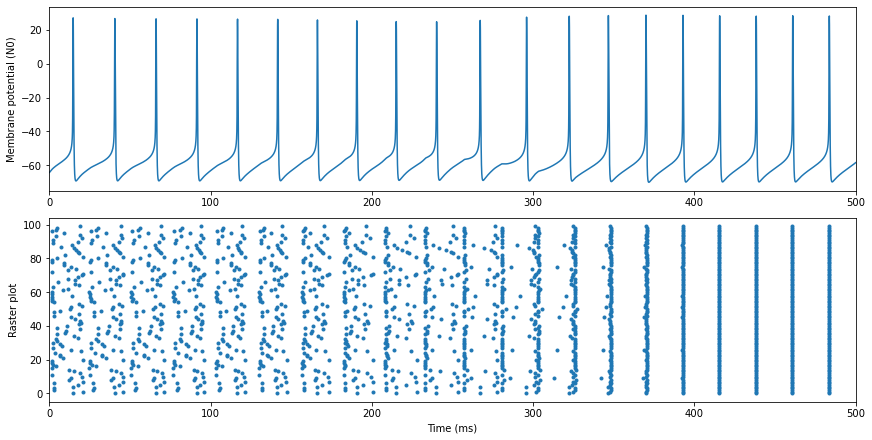

In [21]:
import matplotlib.pyplot as plt

ts = net.ts
fig, gs = bp.visualize.get_figure(2, 1, 3, 12)

fig.add_subplot(gs[0, 0])
plt.plot(ts, neu.mon.V[:, 0])
plt.ylabel('Membrane potential (N0)')
plt.xlim(net.t_start - 0.1, net.t_end + 0.1)

fig.add_subplot(gs[1, 0])
index, time = bp.measure.raster_plot(neu.mon.spike, net.ts)
plt.plot(time, index, '.')
plt.xlim(net.t_start - 0.1, net.t_end + 0.1)
plt.xlabel('Time (ms)')
plt.ylabel('Raster plot')

plt.show()

The full file of this example model can be obtained in [gamma_oscillation](https://brainpy-models.readthedocs.io/en/latest/examples/networks/Gamma_oscillations.html).